# Filippo Conforto - RLab 06

In [1]:
library(tidyverse, quiet = TRUE)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [40]:
find_ci95 = function (pos, lower, upper) {
    low = uniroot(function(y){integrate(pos,lower,y)[[1]] - 0.025}, lower = lower, upper = upper)$root
    up = uniroot(function(y){integrate(pos,y,upper)[[1]] - 0.025}, lower = lower, upper = upper)$root
    return(c(low,up))
    ## Valutare l'uso di qgamma
}

In [27]:
find_median = function (pos, lower, upper) {
    median = uniroot(function(y){integrate(pos,0,y)[[1]] - 0.5}, lower = lower, upper = upper)$root
    return(median)
    ## Valutare di usare qgamma
}

In [29]:
find_mean = function (pos, lower, upper) {
    integrate(function(x) pos(x)*x, lower, upper)[[1]]
}

In [30]:
find_variance = function (pos, lower, upper) {
    integrate(function(x) pos(x)*x^2, lower, upper)[[1]]-find_mean(pos, lower, upper)^2
}

## Exercise 1

Analiticamente ci sono i valori su wikipedia

In [72]:
unif_post= function(x){
    dgamma(x,13,5)
}

In [47]:
factorial(12)/5^13

[1] 0.3923981

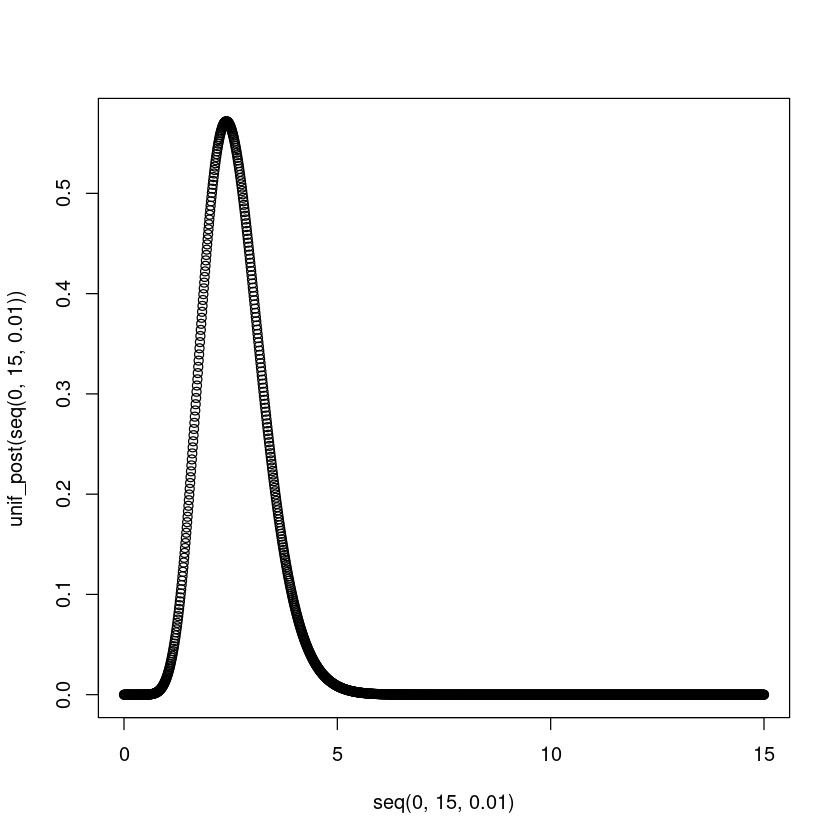

In [68]:
plot(seq(0,15,0.01),unif_post(seq(0,15,0.01)))

In [80]:
find_mean(unif_post, 0, 15)

[1] 2.6

In [81]:
find_median(unif_post, 0, 15)

[1] 2.533646

In [82]:
find_variance(unif_post, 0, 15)

[1] 0.52

In [43]:
find_ci95(unif_post, 0, 15)

[1] 1.384418 4.192317

In [124]:
qnorm(0.025,mean = find_mean(unif_post, 0, 15), sd = sqrt(find_variance(unif_post, 0, 15)))

[1] 1.18665

In [125]:
qnorm(0.975,mean = find_mean(unif_post, 0, 15), sd = sqrt(find_variance(unif_post, 0, 15)))

[1] 4.01335

In [75]:
jeff_post = function(x){
    dgamma(x,12.5,5)
}

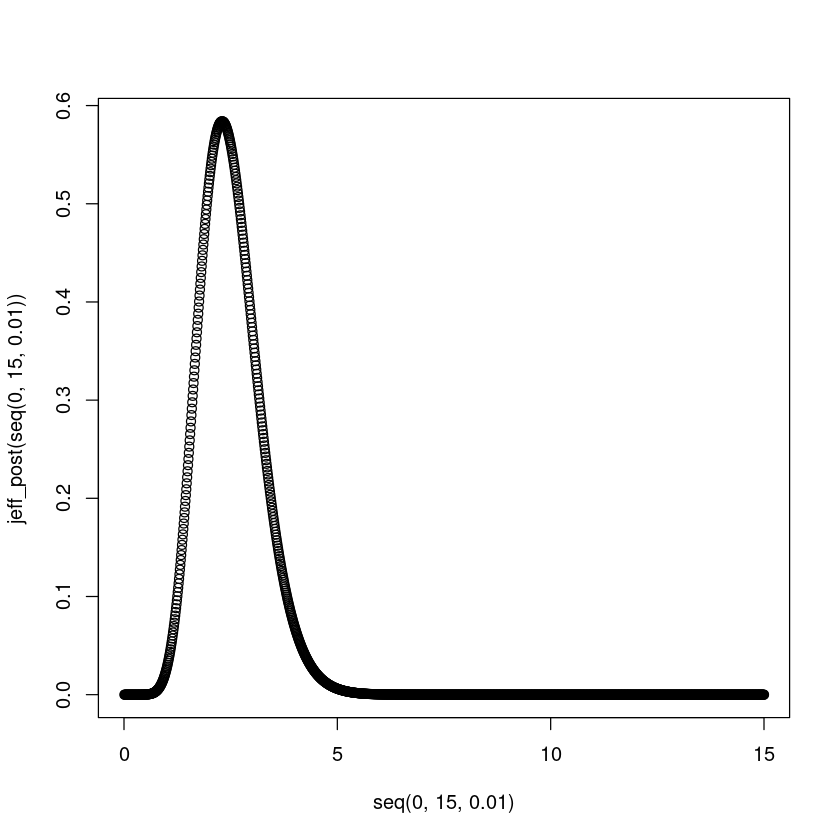

In [63]:
plot(seq(0,15,0.01),jeff_post(seq(0,15,0.01)))

In [76]:
find_mean(jeff_post, 0, 15)

[1] 2.5

In [77]:
find_median(jeff_post, 0.1, 15)

[1] 2.433659

In [78]:
find_variance(jeff_post, 0, 15)

[1] 0.5

In [79]:
find_ci95(jeff_post, 0.1, 15)

[1] 1.311974 4.064646

In [121]:
qnorm(0.025,mean = find_mean(jeff_post, 0, 15), sd = sqrt(find_variance(jeff_post, 0, 15)))

[1] 1.114096

In [123]:
qnorm(0.975,mean = find_mean(jeff_post, 0, 15), sd = sqrt(find_variance(jeff_post, 0, 15)))

[1] 3.885904

## Exercise 2

In [2]:
## Sampler
samp = function(n, alpha =1, beta =1){
    return(tan(runif(n,min = -pi/2, max = pi/2))*beta + alpha)
}

In [3]:
likelyhood = function(x,alpha=1,beta=1){
    beta/(pi*(beta^2+(x-alpha)^2))
}

In [4]:
update_grid = function (grid,x,a,b){
    for(j in 1: length (a)) {
        for(k in 1: length (b)) {
            grid[j,k] <- likelyhood(x,a[j],b[k])*grid[j,k]
            }
        }
    return(grid/(sum(grid*0.04^2)))
    }

In [5]:
alim <- c(0, 4.0)
blim <- c(0, 4)
Nsamp <- 100
uniGrid <- seq(from=1/(2* Nsamp),
to=1-1/(2*Nsamp), by=1/ Nsamp)
delta_a <- diff(alim )/ Nsamp
delta_b <- diff(blim )/ Nsamp
a <- alim[1] + diff(alim )* uniGrid
b <- blim[1] + diff(blim )* uniGrid

In [10]:
grid = matrix ( data = rep(1/10000,10000), nrow = length(a), ncol = length(b))

In [11]:
sample = samp(1000)

In [12]:
for(i in sample){
    grid = update_grid(grid, i,a,b)
}

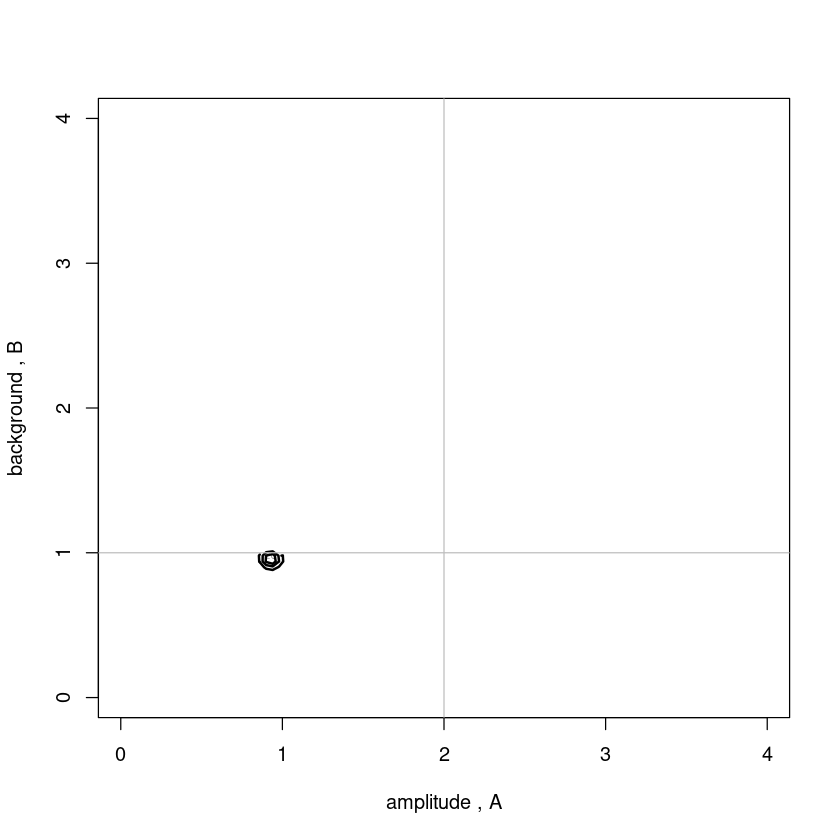

In [13]:
contour (a, b, grid,
    nlevels = 5,
    labcex = 0.5,
    lwd = 2,
    xlab="amplitude , A",
    ylab="background , B")
abline (v=2,h=1,col="grey")

## Exercise 3

In [8]:
# - Generative model
signal <- function (x, a, b, x0, w, t) {
t * (a*exp (-(x-x0)^2/(2*w^2)) + b)
}

log.post <- function (d, x, a, b, x0, w, t) {
    if(a<0 || b <0) { return (-Inf )} # the effect of the prior
    sum( dpois(d, lambda = signal (x, a, b, x0, w, t), log=TRUE ))
}
c_plot = function(ddat , xdat){
    z <- matrix (data=NA , nrow= length (a), ncol= length (b))
    for(j in 1: length (a)) {
    for(k in 1: length (b)) {
            z[j,k] <- log.post(ddat , xdat , a[j], b[k], x0, w, Delta.t)
        }
    }
    z <- z - max(z) # set maximum to zero
    contour (a, b, exp(z),
    nlevels = 5,
    labcex = 0.5,
    lwd = 2,
    xlab="amplitude , A",
    ylab="background , B")
    abline (v=2,h=1,col="grey")
    return(z)
}
results = function(z){
    # Compute normalized marginalized posteriors , P(a|D) and P(b|D)
    # by summing over other parameter . Normalize by gridding .
    p_a_D <- apply(exp(z), 1, sum)
    p_a_D <- p_a_D/( delta_a*sum(p_a_D))
    p_b_D <- apply(exp(z), 2, sum)
    p_b_D <- p_b_D/( delta_b*sum(p_b_D))
    # Compute normalized conditional posteriors , P(a|b,D) and P(b|a,D)
    # using true values of conditioned parameters . Vectorize (func , par)
    # makes a vectorized function out of func in the parameter par.
    p_a_bD <- exp( Vectorize (log.post , "a")(ddat , xdat , a, B.true ,
    x0, w, Delta.t))
    p_a_bD <- p_a_bD/( delta_a*sum(p_a_bD))
    p_b_aD <- exp( Vectorize (log.post , "b")( ddat , xdat , A.true , b,
    x0, w, Delta.t))
    p_b_aD <- p_b_aD/( delta_b*sum(p_b_aD))
    # Compute normalized marginalized posteriors , P(a|D) and P(b|D)
    # by summing over other parameter . Normalize by gridding .
    p_a_D <- apply(exp(z), 1, sum)
    p_a_D <- p_a_D/( delta_a*sum(p_a_D))
    p_b_D <- apply(exp(z), 2, sum)
    p_b_D <- p_b_D/( delta_b*sum(p_b_D))
    # Compute mean , standard deviation , covariance , correlation , of A and B
    mean_a <- delta_a * sum(a * p_a_D)
    mean_b <- delta_b * sum(b * p_b_D)
    sd_a <- sqrt( delta_a * sum ((a-mean_a)^2 * p_a_D) )
    sd_b<- sqrt( delta_b * sum ((b-mean_b)^2 * p_b_D) )
    return(c(mean_a,mean_b,sd_a,sd_b))
}
def

In [2]:
# Define model
x0 <- 0
w<-1
A.true <- 2 #
B.true <- 1 #
Delta.t <- 5 #
set.seed(205)
xdat <- seq(from=-7*w, to=7*w, by=0.5*w)
s.true <- signal (xdat , A.true , B.true , x0, w, Delta.t)
ddat <- rpois( length (s.true), s.true)

In [3]:
alim <- c(0.0, 4.0)
blim <- c(0.5, 1.5)
Nsamp <- 100
uniGrid <- seq(from=1/(2* Nsamp ),
to=1-1/(2*Nsamp), by=1/ Nsamp )
delta_a <- diff(alim )/ Nsamp
delta_b <- diff(blim )/ Nsamp
a <- alim[1] + diff(alim )* uniGrid
b <- blim[1] + diff(blim )* uniGrid

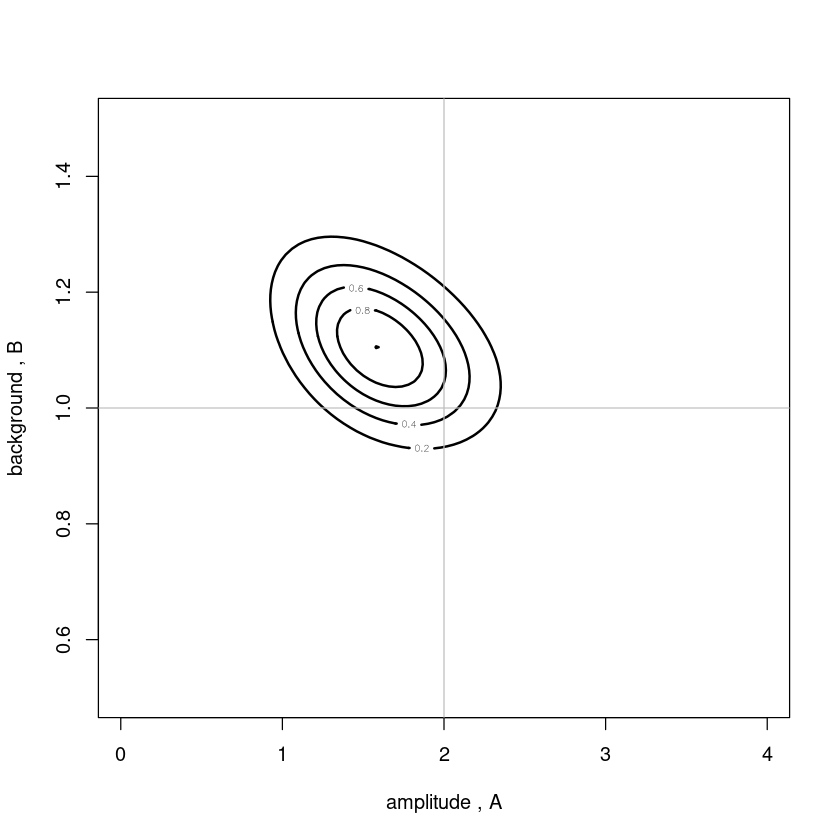

In [5]:
z = c_plot(ddat,xdat)

In [11]:
mean_a = results(z)[[1]]
mean_b = results(z)[[2]]
sd_a = results(z)[[3]]
sd_b = results(z)[[4]]
cov_ab <- 0
for(j in 1: length (a)) {
for(k in 1: length (b)) {
cov_ab <- cov_ab + (a[j]-mean_a)*(b[k]-mean_b)* exp(z[j,k])
}
}

cov_ab <- cov_ab / sum(exp(z))
rho_ab <- cov_ab / (sd_a * sd_b)

cat("a = ", mean_a, "+/-", sd_a, "\n")
cat("b = ", mean_b, "+/-", sd_b, "\n")
cat("rho = ", rho_ab , "\n")

a =  1.630189 +/- 0.3983222 
b =  1.111212 +/- 0.1020915 
rho =  -0.3968818 


In [18]:
# Define model
x0 <- 0
w<-0.1
A.true <- 2 #
B.true <- 1 #
Delta.t <- 5 #
set.seed(205)
xdat1 <- seq(from=-7*w, to=7*w, by=0.5*w)
s.true1 <- signal (xdat , A.true , B.true , x0, w, Delta.t)
ddat1 <- rpois( length (s.true), s.true)

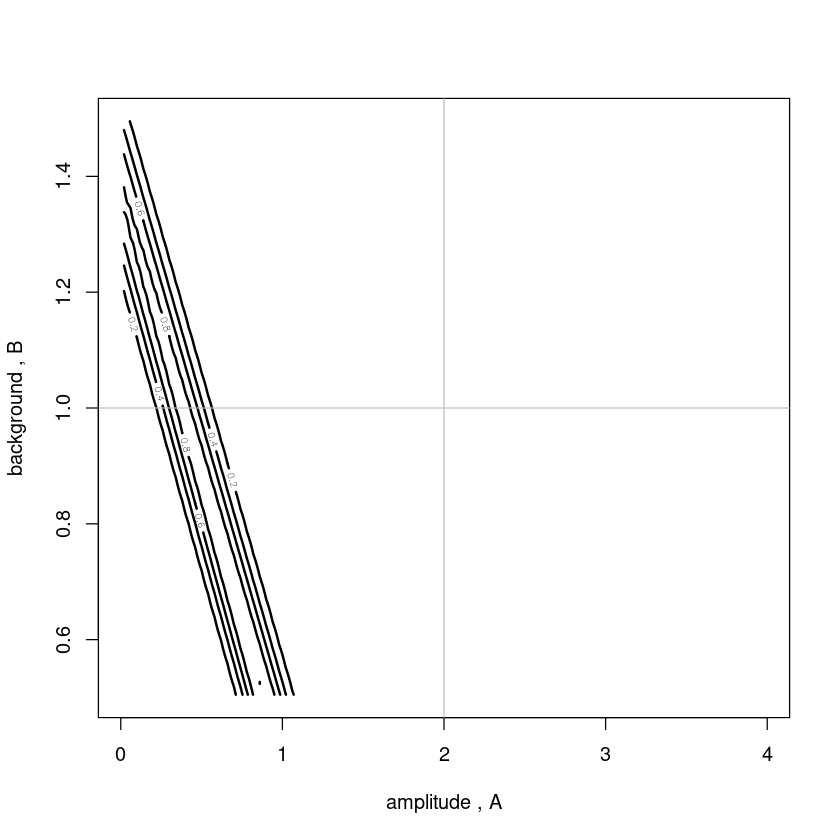

In [23]:
z1 = c_plot(ddat1,xdat1)

In [24]:
mean_a = results(z1)[[1]]
mean_b = results(z1)[[2]]
sd_a = results(z1)[[3]]
sd_b = results(z1)[[4]]
cov_ab <- 0
for(j in 1: length (a)) {
for(k in 1: length (b)) {
cov_ab <- cov_ab + (a[j]-mean_a)*(b[k]-mean_b)* exp(z[j,k])
}
}

cov_ab <- cov_ab / sum(exp(z))
rho_ab <- cov_ab / (sd_a * sd_b)

cat("a = ", mean_a, "+/-", sd_a, "\n")
cat("b = ", mean_b, "+/-", sd_b, "\n")
cat("rho = ", rho_ab , "\n")

a =  0.4717506 +/- 0.2664341 
b =  0.9289297 +/- 0.2604752 
rho =  2.810153 
